In [32]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import transform
import spectral.io.envi as envi

In [10]:
find_index = lambda x, wvls: np.argmin(np.abs(wvls - x), axis = 0)

# 1. LIBS Data Loader

In [21]:
data_folder = r"F:/Data/Data_LIBS/Rock_QLMA/"
hf = h5py.File(data_folder + 'mini_bife_80x80(train).h5', 'r') #'mini_bife_100x110.h5', 'r')
spectrums = np.array(hf.get('intensities'))[1:]
positions = np.array(hf.get('position'))[1:]
wavelengths = np.array(hf.get('wavelengths'))
hf.close()

In [22]:
def make_data_map(spectrums, positions):
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes,:]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, positions

In [23]:
libs_maps, libs_positions = make_data_map(spectrums, positions)

(80, 80, 14336)


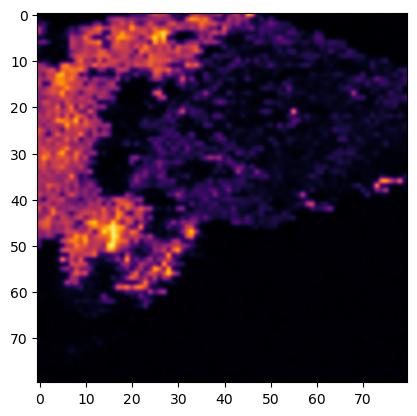

In [31]:
plt.subplots()
plt.imshow(libs_maps[:, :, find_index(610.22, wavelengths)], 
           cmap = 'inferno', interpolation = 'gaussian')

# 2. HSI Data Loader

In [33]:
filen = 'Cavali_amostras_test_A2_2022-05-31_12-38-48'
filen = 'Cavali_amostras_test_A3_2022-05-31_12-40-21'
folder = 'F:/Data/Data_HSI/SWIR_' + filen + '/capture/'


dark_ref = envi.open(folder+'DARKREF_SWIR_' + filen + '.hdr', 
                     folder+'DARKREF_SWIR_' + filen + '.raw')
white_ref = envi.open(folder+'WHITEREF_SWIR_' + filen + '.hdr', 
                      folder+'WHITEREF_SWIR_' + filen + '.raw')
data_ref = envi.open(folder+'SWIR_' + filen + '.hdr', 
                     folder+'SWIR_' + filen + '.raw')

c:\Users\tomas\Programming\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


# 2.1 HSI pre-processing

The data used for HSI is preprocessed. In other words it is calibrated in accordance to a white and dark reference

In [35]:
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())
print(data_nparr.shape)

corrected_nparr = np.divide(data_nparr-dark_nparr.mean(axis = 0),
                            white_nparr.mean(axis = 0)-dark_nparr.mean(axis = 0)) #from reference

(354, 384, 284)


C:\Users\tomas\AppData\Local\Temp\ipykernel_20860\3597193224.py:6: RuntimeWarning: invalid value encountered in true_divide
  corrected_nparr = np.divide(data_nparr-dark_nparr.mean(axis = 0),


# 3. Dataset Aligment

In [36]:
im1 = corrected_nparr[100:250, 100:320, 200]
mmap = libs_maps[:, :, find_index(588.95, wavelengths)]

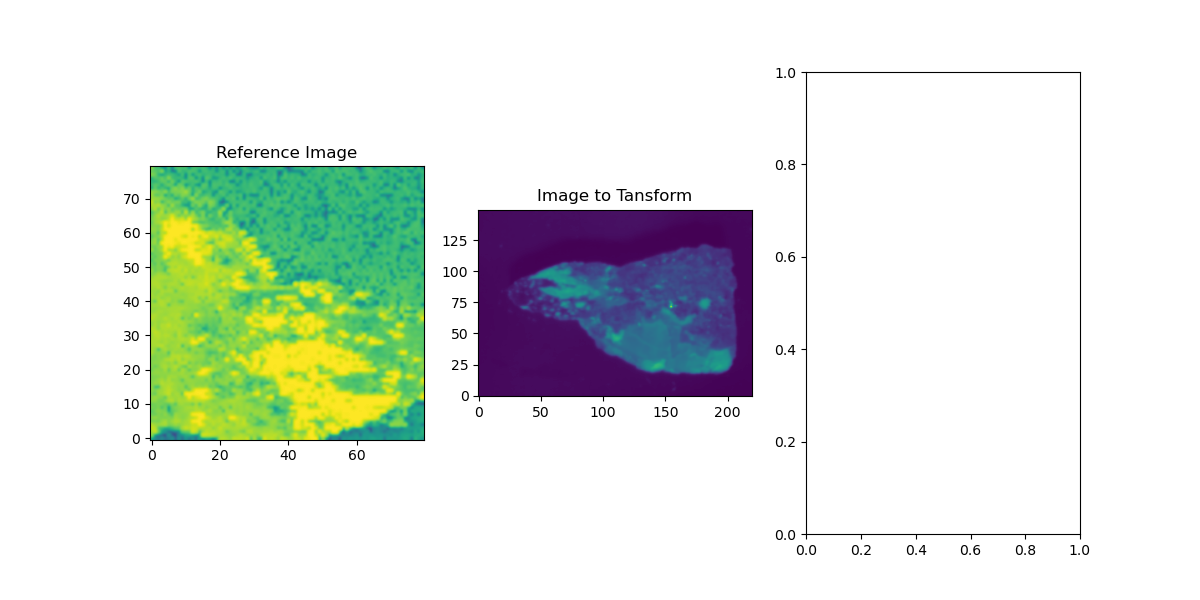

In [39]:
%matplotlib widget
aligner = transform.align(mmap, im1)

In [44]:
aligner.transform(corrected_nparr[100:250, 100:320])
new_hyper = aligner.new_data

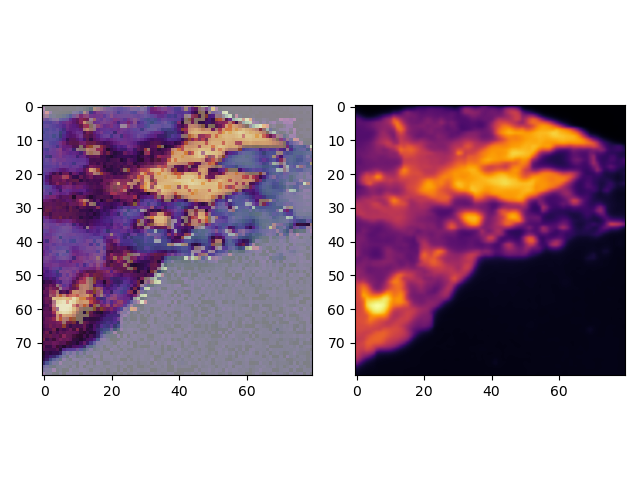

In [56]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
ax.imshow(libs_maps[:, :, find_index(588.95, wavelengths)], 
           cmap = 'inferno', interpolation = 'None')
ax.imshow(new_hyper[:, :, 200], 
           cmap = 'twilight', interpolation = 'None', 
           alpha = 0.6)

ax = axs[1]
ax.imshow(new_hyper[:, :, 200], 
           cmap = 'inferno', interpolation = 'gaussian')

fig.tight_layout()

# 4. Save Dataset for training

In [57]:
np.save("F:/Data/Data_Deep/aligner_hyper.npy", new_hyper)
np.save("F:/Data/Data_Deep/aligner_libs.npy", libs_maps)

In [60]:
np.save("F:/Data/Data_Deep/hyper_bands.npy", data_ref.bands.centers)
np.save("F:/Data/Data_Deep/libs_wavelengths.npy", wavelengths)